In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import numpy as np
from numpy import random
# Set seed for reproducibility
np.random.seed(42)

from scipy.stats import chi2
from scipy.special import erfcinv, erfinv
from scipy.linalg import sqrtm, inv


import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

In [2]:
from numpy.linalg import inv

def calculate_R_CM(vectors):
    num_vectors = len(vectors)
    R_CM = np.sum(vectors, axis=0) / num_vectors
    return R_CM

#Sharp triangle
num_datasets=3
num_parameters=2
df=num_datasets*num_parameters
n_samples = int(1e6)
num_samples_sigma = 1000
#n_samples = int(1e4)
# Parameters
d = num_parameters  # Dimension
N = num_datasets  # Number of datasets
L = N*(N-1)/2  # Number of tension vectors

def W_ij(diff_mean_i, diff_mean_j, cov_i, cov_j, n_samples = n_samples):
  # Precompute square root of inverse covariance matrices
  sqrt_inv_cov_i = sqrtm(inv(cov_i))
  sqrt_inv_cov_j = sqrtm(inv(cov_j))

  # Sampling
  X = np.random.multivariate_normal(diff_mean_i, cov_i, size=n_samples).T
  Y = np.random.multivariate_normal(diff_mean_j, cov_j, size=n_samples).T

  # Compute W using precomputed matrices and einsum
  W = np.einsum('ij,ij->i', np.dot(sqrt_inv_cov_i, X).T, np.dot(sqrt_inv_cov_j, Y).T)
  return W

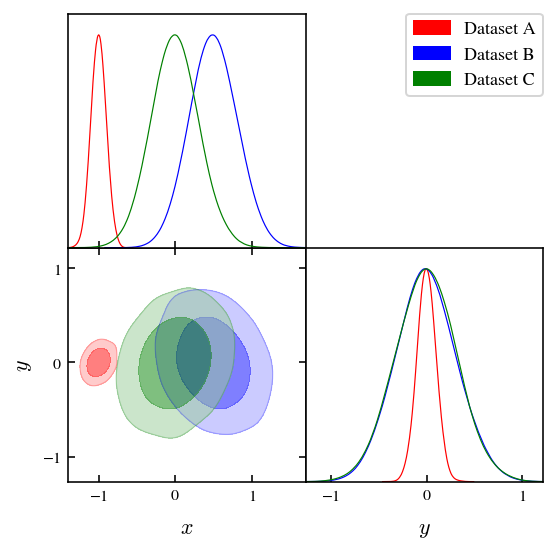

In [3]:
mean_A = np.array([-1., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0., 0.])

cov_A = np.array([[1, 0.2], [0.2, 1]])/100
cov_B = np.array([[1, -0.2], [-0.2, 1]])/10
cov_C = np.array([[1, 0.2], [0.2, 1]])/10

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

names = ['x', 'y']
labels = ['x', 'y']

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green']

g = plots.get_subplot_plotter()
g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors)




In [ ]:
rand_mean_A = np.random.multivariate_normal(mean_A, cov_A, size=num_samples_sigma)
rand_mean_B = np.random.multivariate_normal(mean_B, cov_B, size=num_samples_sigma)
rand_mean_C = np.random.multivariate_normal(mean_C, cov_C, size=num_samples_sigma)

# Precompute covariance sums and their inverses
cov_sums = [cov_A + cov_B, cov_A + cov_C, cov_B + cov_C]
sqrt_inv_covs = [sqrtm(inv(cov)) for cov in cov_sums]

# Precompute differences of means
diff_means = [
    rand_mean_A - rand_mean_B,
    rand_mean_A - rand_mean_C,
    rand_mean_B - rand_mean_C
]

output = np.zeros(num_samples_sigma)
for i in range(num_samples_sigma):
    # Extract current means
    mean_A, mean_B, mean_C = rand_mean_A[i], rand_mean_B[i], rand_mean_C[i]

    # Compute W values
    W_values = [
        W_ij(diff_means[0][i], diff_means[1][i], cov_sums[0], cov_sums[1]),
        W_ij(diff_means[0][i], diff_means[2][i], cov_sums[0], cov_sums[2]),
        W_ij(diff_means[1][i], diff_means[2][i], cov_sums[1], cov_sums[2])
    ]

    W_tot = np.sum(W_values, axis=0)
    Q_tot = np.random.chisquare(df=d * N, size=n_samples)
    R_tot = (W_tot + Q_tot) / L**2

    # Compute r vectors
    r_vectors = [
        np.dot(sqrt_inv_covs[0], mean_A - mean_B),
        np.dot(sqrt_inv_covs[1], mean_A - mean_C),
        np.dot(sqrt_inv_covs[2], mean_B - mean_C)
    ]

    # Calculate R_CM and PTE
    R_CM = calculate_R_CM(np.array(r_vectors))
    
    #In terms of PTE
    #PTE = R_tot[R_tot >= np.linalg.norm(R_CM)**2].size / R_tot.size
    #PTE = np.mean(R_tot >= np.linalg.norm(R_CM)**2)
    #n_sigma = np.sqrt(2) * erfcinv(PTE)
    
    #In terms of P (montecarlo integration)
    P = np.mean(R_tot <= np.linalg.norm(R_CM)**2)
    #P = R_tot[R_tot <= np.linalg.norm(R_CM)**2].size / R_tot.size
    n_sigma = np.sqrt(2) * erfcinv(1-P)

    output[i] = n_sigma
    

In [8]:
print(output)
# Masking infinite values
inf_mask = np.isinf(output)
# Filtering out the infinite values
filtered_output = output[~inf_mask]
print(filtered_output)

[4.11332542 2.99605177 4.26489079 3.09486876 2.75162712 1.45877517
 4.2240038  1.91142489 3.61443786 3.00647015        inf 4.49368851
 2.66617388 3.57293678 3.86300656        inf 3.2572432         inf
 2.59142274 3.60847684 2.53253829        inf 2.48917479 3.2922195
 4.67081982        inf 2.86093023 3.61357838 2.09310256 1.22337789
 4.89163848 4.89163848 2.30365532 3.32160905 3.12616858        inf
 2.15412973 4.46518392 3.25699101 3.54947508 4.61138236 2.80690494
        inf        inf 3.00820015 3.43342821 3.88341394        inf
 3.68245351 4.52638932 2.0460241  4.67081982        inf 3.50302864
 2.45419599 2.57290117 2.29010898 2.20641437 4.09073945 3.2544804
 4.89163848 2.52408463        inf 3.45563411 1.83153318 4.67081982
 3.12155278 3.76432436 4.89163848 4.16599316 3.2485373  3.04291308
 3.48344761 2.88037692 4.89163848 3.93269154 4.75342431 3.23698444
 2.72505899 3.12699988 4.52638932 4.17346634 3.99026325 3.95355051
        inf 3.19444495 3.6093206  2.7273256  3.08978712 2.926136

In [9]:
#print("Mean n_sigma: ", np.mean(output))
#print("Standard deviation n_sigma: ", np.std(output))
print("Mean n_sigma: ", np.mean(filtered_output))
print("Standard deviation n_sigma: ", np.std(filtered_output))

Mean n_sigma:  3.427284379050963
Standard deviation n_sigma:  0.8397212383260158


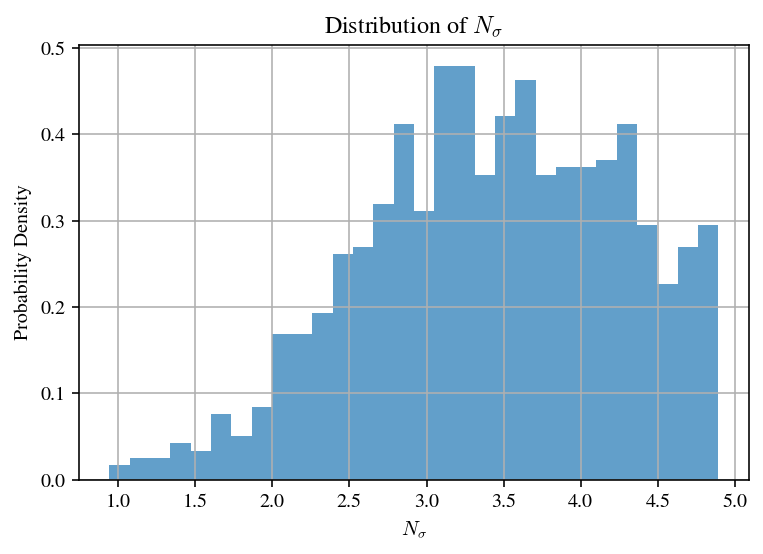

In [10]:
# Plot histogram
plt.hist(filtered_output, bins=int(np.sqrt(len(filtered_output))), density=True, alpha=0.7)
plt.title('Distribution of $N_\sigma$')
plt.xlabel('$N_\sigma$')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()